In [56]:
import torch, pandas as pd, matplotlib.pyplot as plt, numpy as np, random, timeit
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [57]:
# Constantes
RANDON_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40 
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 1e-3
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (
    0.9,
    0.999
)
ACTIVATION_FN = "gelu"
NUM_ENCODERS = 4
EMBED_DIM =  (PATCH_SIZE ** 2) * IN_CHANNELS # (4^2) * 1 = 16
NUM_PATCHS = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDON_SEED)
np.random.seed(RANDON_SEED)
torch.manual_seed(RANDON_SEED)
torch.cuda.manual_seed(RANDON_SEED)
torch.cuda.manual_seed_all(RANDON_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
# Classe para Patching as imagens

class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patchs, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
                
            ),
            nn.Flatten(2)
        )
        
        # Onde fazer a classificação
        self.cls_token = nn.Parameter(torch.randn(size = (1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patchs+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        
        return x
        

In [59]:
# Testando codagem feita
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHS, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)

torch.Size([512, 50, 16])


In [60]:
class ViT(nn.Module):
    def __init__(
        self,
        num_patches,
        img_size,
        num_classes,
        patch_size,
        embed_dim,
        num_encoders,
        num_heads,
        hidden_dim,
        dropout,
        activation,
        in_channels,
    ):
        super().__init__()
        self.embeddings_block = PatchEmbedding(
            embed_dim, patch_size, num_patches, dropout, in_channels
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True,
        )
        self.encoder_blocks = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoders
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        
        return x

In [61]:
model = ViT(
    NUM_PATCHS, 
    IMG_SIZE, 
    NUM_CLASSES, 
    PATCH_SIZE, 
    EMBED_DIM,
    NUM_ENCODERS,
    NUM_HEADS,
    HIDDEN_DIM,
    DROPOUT,
    ACTIVATION_FN,
    IN_CHANNELS
    ).to(device)
x = torch.rand(512, 1, 28, 28)
print(model(x).shape)

/home/gus/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


In [62]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [63]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDON_SEED, shuffle=True)

In [66]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index) -> any:
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        label = self.labels[index]
        index = self.indicies[index]
        image = self.transform(image)
        
        return {
            "image": image,
            "label": label,
            "index": index
        }

In [67]:
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        label = self.labels[index]
        index = self.indicies[index]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [68]:
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies) -> None:
        super().__init__()
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[index]
        image = self.transform(image)

        return {"image": image, "index": index}

In [69]:
train_dataset = MNISTTrainDataset(
    train_df.iloc[:, 1:].values.astype(np.uint8),
    train_df.iloc[:, 0].values,
    train_df.index.values
)
val_dataset = MNISTValDataset(
    val_df.iloc[:, 1:].values.astype(np.uint8),
    val_df.iloc[:, 0].values,
    val_df.index.values,
)
test_dataset = MNISTSubmitDataset(
    test_df.values.astype(np.uint8),
    test_df.index.values
)

<Figure size 640x480 with 0 Axes>

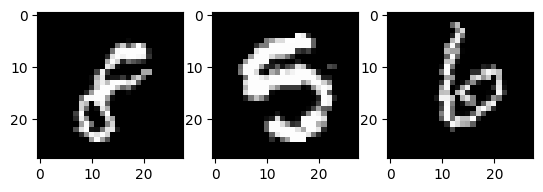

In [70]:
plt.figure()
f, axarr = plt.subplots(1, 3)
for i in range(3):
    axarr[i].imshow(train_dataset[i]["image"].squeeze(), cmap="gray")

In [71]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), 
    betas=ADAM_BETAS, 
    lr=LEARNING_RATE, 
    weight_decay=ADAM_WEIGHT_DECAY
)

In [77]:
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels, train_preds, train_running_loss = [], [], 0

    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels, val_preds, val_running_loss = [], [], 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(
        f"Train accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}"
    )
    print(
        f"Validation accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}"
    )


stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▎         | 1/40 [03:20<2:10:05, 200.15s/it]

------------------------------
Train Loss EPOCH 1: 1.8097
Validation Loss EPOCH 1: 1.6145
Train accuracy EPOCH 1: 0.3817
Validation accuracy EPOCH 1: 0.4843


  5%|▌         | 2/40 [06:44<2:08:17, 202.55s/it]

------------------------------
Train Loss EPOCH 2: 1.5716
Validation Loss EPOCH 2: 1.4062
Train accuracy EPOCH 2: 0.5016
Validation accuracy EPOCH 2: 0.5883


  5%|▌         | 2/40 [08:36<2:43:25, 258.04s/it]


KeyboardInterrupt: 

In [ ]:
labels, ids, imgs = [], [], []

model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i) + 1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1